# Training

## Imports

In [1]:
import os
os.chdir(os.getcwd() + "/Code")

import pytorch_lightning as pl
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import statistics
import seaborn as sns

from src.Network import RegressionNet
from src import Dataset, DecisionMaker
os.chdir(os.path.dirname(os.getcwd()))

%load_ext autoreload
%autoreload 2

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## Model

In [2]:

# Hyperparameter
hparams = {
    "days_of_data": 64,
    "batch_size": 512,
    "lr": 0.01,
    "n_hidden": 400,
    "layers": 1,
    "optim": "Adam",
    "weight_decay": 0.0,
    "loss": "MSE",
    "to_predict": "Close",
    "label_type": "real",
    "normalize": False,
}

In [3]:
# Model initialization
model = RegressionNet.RegressionNet(hparams=hparams)
# wandb.watch(model)

loss is MSE
Cuda available: True
Device: cuda:0


## Trainer

In [4]:
# more Hyperparameter
gpus=1
max_epochs=125
# min_epochs =
fast_dev_run = True
overfit_pct = 0.25


In [5]:
# os.chdir(os.path.dirname(os.getcwd()))
# Trainer initialization
trainer = pl.Trainer(
    gpus=gpus,
    max_epochs=max_epochs,
#     fast_dev_run = fast_dev_run,
#     min_epochs=min_epochs,
#     auto_scale_batch_size='binsearch',
#     auto_lr_find=auto_lr_find,
#     checkpoint_callback=checkpoint_callback,
#     overfit_pct=overfit_pct,

)

GPU available: True, used: True
No environment variable for node rank defined. Set as 0.
CUDA_VISIBLE_DEVICES: [0]


In [6]:
# train model
trainer.fit(model)

loading computed_Close_real_norm-False_threshold-0_ADBE.csv
loading computed_Close_real_norm-False_threshold-0_AMD.csv
loading computed_Close_real_norm-False_threshold-0_GOOG.csv
loading computed_Close_real_norm-False_threshold-0_INTC.csv
loading computed_Close_real_norm-False_threshold-0_MSFT.csv
loading computed_Close_real_norm-False_threshold-0_NFLX.csv
loading computed_Close_real_norm-False_threshold-0_NVDA.csv
loading computed_Close_real_norm-False_threshold-0_PYPL.csv
loading computed_Close_real_norm-False_threshold-0_SHOP.csv
loading computed_Close_real_norm-False_threshold-0_TSLA.csv
loading computed_Close_real_norm-False_threshold-0_FB.csv
loading computed_Close_real_norm-False_threshold-0_AAPL.csv
Dataset length: 56694
train_size: 45356
val_size: 11338
test_size: 9885



  | Name   | Type        | Params
-----------------------------------
0 | lstm   | Sequential  | 652 K 
1 | lstm.0 | LSTM        | 652 K 
2 | fc1    | Sequential  | 161 K 
3 | fc1.0  | Linear      | 160 K 
4 | fc1.1  | BatchNorm1d | 800   
5 | fc1.2  | PReLU       | 1     
6 | fc2    | Sequential  | 401   
7 | fc2.0  | Linear      | 401   


optim is Adam


Epoch     8: reducing learning rate of group 0 to 1.0000e-03.


Epoch    25: reducing learning rate of group 0 to 1.0000e-04.


Epoch    42: reducing learning rate of group 0 to 1.0000e-05.


Epoch    59: reducing learning rate of group 0 to 1.0000e-06.


1

In [7]:
path = os.getcwd() + "/Code/Saved Models/model.pth"

# torch.save(model, path)

# model = torch.load(path)
model.eval()
trainer.test()

--------------------------------------------------------------------------------
TEST RESULTS
{'test_loss': tensor(7389.7549, device='cuda:0')}
--------------------------------------------------------------------------------



## Evaluate

LSTM(6, 400)
weight_ih_l0


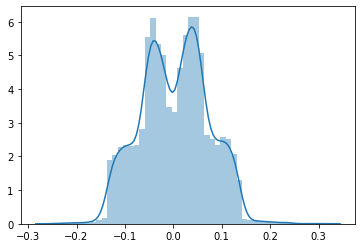

weight_hh_l0


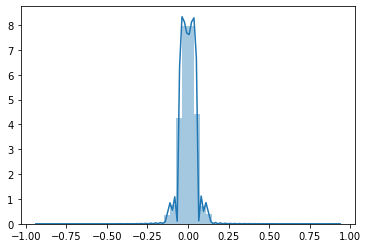

bias_ih_l0


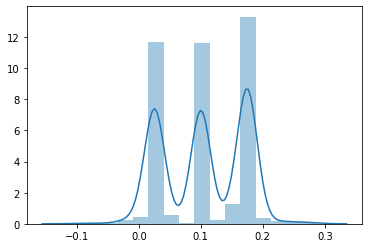

bias_hh_l0


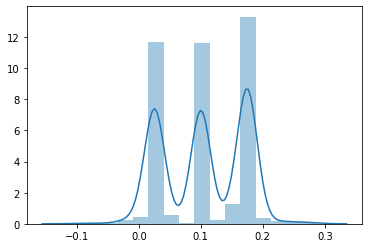

Linear(in_features=400, out_features=400, bias=True)


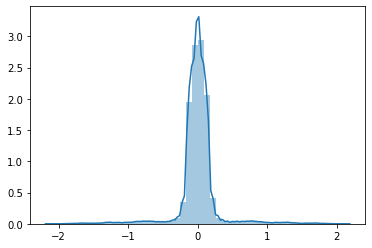

Linear(in_features=400, out_features=1, bias=True)


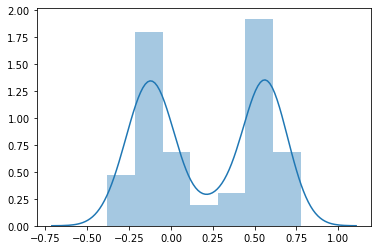

In [8]:
for m in model.modules():
    if isinstance(m, nn.Linear):
        print(m)
        sns.distplot(m.weight.data.cpu())
        plt.show()
    if isinstance(m, nn.Conv2d):
        print(m)
        sns.distplot(m.weight.data.cpu())
        plt.show()
    if isinstance(m, nn.LSTM):
        print(m)
        for name, param in m.named_parameters():
            if 'bias' in name:
                print(name)
                sns.distplot(param.data.cpu())
                plt.show()
            if 'weight' in name:
                print(name)
                sns.distplot(param.data.cpu())
                plt.show()

In [9]:
root = os.getcwd()

dataset = Dataset.StockDataset(
    csv_file=root + "/Data/test/AAPL.csv", 
    days_of_data=model.hparams["days_of_data"], 
    to_predict=model.hparams["to_predict"],
    label_type=model.hparams["label_type"],
    normalize=model.hparams["normalize"],
    training=False,
)
# print(dataset.__getitem__(0))

computing computed_Close_real_norm-False_threshold-0_AAPL.csv ...
computing finished.


In [10]:
y_hat_list = []
y_list = []
y_hat_norm_list = []
y_norm_list = []
acc_list = []
n = dataset.__len__()
print(n)
for i in range(n):
    with torch.no_grad():
        data, label, date = dataset.__getitem__(dataset.__len__() - n + i)
        
#         data = torch.reshape(data, (1, -1))
        data = data.unsqueeze(0)
        label =  label.to(device)
        data = data.to(device)
        label = label.to(device)
        
        model.eval()
        model.to(device)
#         print(model.forward(data))
        y_hat = model.forward(data).item()
        y_hat_list.append(y_hat)
#         y_hat = ((y_hat + 1) / 2) * (date[2][1].item() - date[2][0].item()) + date[2][0].item()
#         y_hat_norm_list.append(y_hat)
        y = label.item()
        y_list.append(y)
#         y = date[4].item()
#         y_norm_list.append(y)
        acc = y - y_hat
        acc_list.append(acc)

9885


/home/thilo/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:288: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)


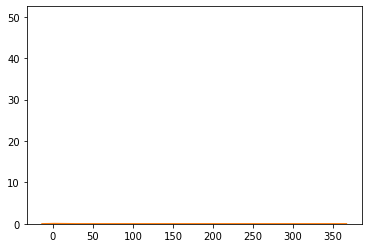

Min y: 0.19642899930477142 Min y_hat: 81.56417846679688
Max y: 352.8399963378906 Max y_hat: 81.56417846679688
Avg y: 34.35300313927606 Avg y_hat: 81.56417846679688
Min acc: -81.3677494674921
Max acc: 271.27581787109375
Avg acc: -47.21117532752081
Std dev y: 61.82370558987527 Std dev acc: 61.82370558987527
------------------------


In [11]:
sns.distplot(y_hat_list)
sns.distplot(y_list)
plt.show()


print("Min y:", min(y_list), "Min y_hat:", min(y_hat_list))
print("Max y:", max(y_list), "Max y_hat:", max(y_hat_list))
print("Avg y:", sum(y_list) / len(y_list), "Avg y_hat:", sum(y_hat_list) / len(y_hat_list))
print("Min acc:", min(acc_list))
print("Max acc:", max(acc_list))
print("Avg acc:", sum(acc_list) / len(acc_list))
print("Std dev y:", statistics.stdev(y_list), "Std dev acc:", statistics.stdev(acc_list))
print("------------------------")
# print("Min y:", min(y_norm_list), "Min y_hat:", min(y_hat_norm_list))
# print("Max y:", max(y_norm_list), "Max y_hat:", max(y_hat_norm_list))
# print("Avg y:", sum(y_norm_list) / len(y_norm_list), "Avg y_hat:", sum(y_hat_norm_list) / len(y_hat_norm_list))


In [12]:
if model.hparams["label_type"]  is "real":
    n = 100
    trader = DecisionMaker.DecisionMaker()
    pred_norm, pred = trader.show_last_n_days_real(model, dataset, n)
    
    label_norm = [d['label'] for d in pred_norm]
    y_hat_norm = [d['predicted'] for d in pred_norm]
    
    label = [d['label'] for d in pred]
    y_hat = [d['predicted'] for d in pred]
#     print(min(label_norm))
    
    #plt
    y = list(range(n))
    plt.plot(y, label, y, y_hat)
    plt.show()
    plt.plot(y, label_norm, y, y_hat_norm)
    plt.show()


TypeError: unsupported operand type(s) for -: 'NoneType' and 'NoneType'

In [13]:
n = 75
trader = DecisionMaker.DecisionMaker()
pred, long, short = trader.last_n_days(model, dataset, n, model.hparams["label_type"], freshholde=0.01)
label = [d['label'] for d in pred]
y_hat = [d['predicted'] for d in pred]
long_gain = [x["diff"] for x in long]
short_gain =[x["diff"] for x in short]

print(len(long),"long trades, ", len(short), "short trades", len(long) + len(short), "total trades /",n , "\n")

print("Sum:")
print("Long:", sum(long_gain), "Short:", sum(short_gain), "\n")

print("Avg Profit:")
if len(long) > 0:
    print("Long:", sum(long_gain) / len(long), end=' ')
if len(short) > 0:
    print("Short:", sum(short_gain) / len(short))
print("\n")

if len(long) > 0:
    long_idx = np.argmax(long_gain)
    print("Best long day:\n", long[long_idx])
    long_idx = np.argmin(long_gain)
    print("Worst long day:\n", long[long_idx], "\n")
if len(short) > 0:
    short_idx = np.argmin(short_gain)
    print("Best short day:\n", short[short_idx])
    short_idx = np.argmax(short_gain)
    print("Worst short day:\n", short[short_idx])

# plt
# print(pred["predicted"])
y = list(range(n))
plt.plot(y, label, y, y_hat)
plt.show()

TypeError: unsupported operand type(s) for -: 'NoneType' and 'NoneType'

In [ ]:
test = [1,2,3,4,5,6]

a = torch.as_tensor([test, test])
print(a.shape)